In [2]:

import torch
import numpy as np
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm, trange
import os 
import json
import glob

import math
from sentence_transformers import SentenceTransformer




# Création des données

In [3]:

model_w2v = SentenceTransformer('all-mpnet-base-v2')

class Data_pdg():
        
 
    def __init__(self, path, test_size=0.2):
        self.path = path                   
        self.X_train, self.X_test, self.y_train , self.y_test= self.split_train_test(test_size)
        self.train_len, self.test_len = self.get_len() 
      
    
    def get_graph(self, file):
        #print(file)

        with open(file, "r") as source:
            graph= json.load(source)

        edges_cdg=[]
        edges_ddg=[]
        labels=[]
       
        key="label"
        index=0 
        
        
        for obj in graph["objects"]:
            if not key in obj:
                index+=1
            else: 
                labels.append(obj["label"])
                


        for edge in graph["edges"]:
            if edge["style"]=="solid": 
                        edges_cdg.append([edge["head"]-index, edge["tail"]-index])
            else:
                        edges_ddg.append([edge["head"]-index, edge["tail"]-index])
                    
                    

        return labels, edges_cdg, edges_ddg
                         
      
    def get_labels(self, file):

        with open(file, "r") as source:
            graph= json.load(source)


        labels=[]
        key="label"
        for obj in graph["objects"]:
            if key in obj:
                labels.append(obj["label"])
        return labels
       
    
    
    def get_all_labels(self):


        files=[]
        all_labels=set()

        for dirpath, dirnames, files_names in os.walk(self.path):
            if dirpath.endswith("json"):
                        files+=glob.glob(dirpath+"\*.json")

        for file in files :
            all_labels=all_labels.union(set(self.get_labels(file)))

        return all_labels


    def get_graph_pairs(self):

        graph_pairs=dict()
        cases=glob.glob(self.path+"\*", recursive = True)
        for case in cases:
            original=glob.glob(case+"\original\json\*.json")
            plagiarized=glob.glob(case+"\plagiarized\json\*.json")
            non_plagiarized=glob.glob(case+"\\non-plagiarized\json\*.json")
            
            graph_pairs.update({ plagiarized_code:{ "original" : original[0], "target": torch.tensor([1.0]).float()} for plagiarized_code in plagiarized })
            graph_pairs.update({ non_plagiarized_code: { "original" : original[0], "target": torch.tensor([0.0]).float()}  for non_plagiarized_code in non_plagiarized })
             
       
        
        

        return graph_pairs




    def create_pair(self, graph1, graph_original):

            graph_pair=dict()
            labels_graph1=[]
            labels_original=[]
          
            
            
            #fetch both graphs (labels+edges)
            labels_graph1_string, edges_cdg_graph1, edges_ddg_graph1=self.get_graph(graph1)
            labels_original_string, edges_cdg_original, edges_ddg_original=self.get_graph(graph_original)
 
            
            
            #one hot encoding of labels of graph1              
            for label in labels_graph1_string:
                labels_graph1.append(model_w2v.encode(label))


                  
            #one hot encoding of labels of original graph  
            for label in labels_original_string:
                labels_original.append(model_w2v.encode(label))



            edges_cdg_graph1= torch.from_numpy(np.array(edges_cdg_graph1, dtype=np.int64).T).type(torch.long)
            edges_ddg_graph1= torch.from_numpy(np.array(edges_ddg_graph1, dtype=np.int64).T).type(torch.long)
            edges_cdg_original= torch.from_numpy(np.array(edges_cdg_original, dtype=np.int64).T).type(torch.long)
            edges_ddg_original= torch.from_numpy(np.array(edges_ddg_original, dtype=np.int64).T).type(torch.long)



            graph_pair["labels_graph1"]=torch.FloatTensor(np.array(labels_graph1))
            graph_pair["labels_original"]=torch.FloatTensor(np.array(labels_original))
            graph_pair["edges_cdg_graph1"]=edges_cdg_graph1
            graph_pair["edges_ddg_graph1"]=edges_ddg_graph1
            graph_pair["edges_cdg_original"]=edges_cdg_original
            graph_pair["edges_ddg_original"]=edges_ddg_original
           

            return graph_pair

        

    def create_all_pairs(self):
            
            graph_pairs=[]
            targets=[]
            pairs=self.get_graph_pairs()
            length= len(pairs)

            for graph1, graph_original in pairs.items():
                graph_pair= self.create_pair(graph1, graph_original["original"])
                graph_pair["target"]=graph_original["target"].reshape(1, 1)
                graph_pairs.append(graph_pair)
                targets.append(graph_original["target"].reshape(1, 1))

                
            return graph_pairs, targets , length
        
        
    def split_train_test(self, test_size):
        
        
            graph_pairs, targets , length = self.create_all_pairs()
            
            return train_test_split(graph_pairs, targets, test_size=test_size, random_state=42)
            
        
    def get_len(self):
        return len(self.X_train), len(self.X_test) 
        
    def get_X_train(self):
        return self.X_train
    
    def get_X_test(self):
        return self.X_test
    
    def get_y_train(self):
        return self.y_train
    
    def get_y_test(self):
        return self.y_test
    
    

            


In [ ]:
path="..\Dataset"
data=Data_pdg(path, test_size=0.4)

In [29]:
#lire les objets data sauvegardés

import pickle

with open('python_data.pkl', 'rb') as inp:
    data = pickle.load(inp)
    
    
with open('java_data.pkl', 'rb') as inp:
    data2 = pickle.load(inp)

# Modèles

## SVM

In [37]:
#GNN + SVM Classifier

class GNN_SVM(torch.nn.Module):
    
    def __init__(self, number_labels):
        super(GNN_SVM, self).__init__()
        self.number_labels=number_labels
        self.setup_layers()
        
    def setup_layers(self):
        self.SAGEConv1= SAGEConv( self.number_labels, 256 , normalize=True)
        self.SAGEConv2=SAGEConv( 256, 128 , normalize=True)
        self.SAGEConv3=SAGEConv( 128, 64 , normalize=True)
        self.Attention = Attention()
        self.SVM = SVM()
        self.fully_connected = torch.nn.Linear(32, 32)
        self.classifier = torch.nn.Linear(32, 1)
        
        
        
    def nodes_embedding(self, labels, edges, p):
        
        
        
        embedding= self.SAGEConv1(labels, edges)
        embedding= torch.nn.functional.relu(embedding)
        embedding= torch.nn.functional.dropout(embedding, p=p)
        
        
        embedding= self.SAGEConv2(embedding, edges)
        embedding= torch.nn.functional.relu(embedding)
        embedding= torch.nn.functional.dropout(embedding, p=p)
        
        
        embedding= self.SAGEConv3(embedding, edges)
        
        
        return embedding
    
    
    def graph_pair_classification(self, features_graph1, features_original, target):
        
        score = self.SVM(features_graph1, features_original, target)
        score = torch.t(score)

        score = torch.nn.functional.relu(self.fully_connected(score))
        
        score = torch.sigmoid(self.classifier(score))
        
        
        return score
        
        
    
    def forward(self, data, p=0.2):
        
      
        
        labels_graph1=data["labels_graph1"]
        edges_cdg_graph1=data["edges_cdg_graph1"]
        edges_ddg_graph1=data["edges_ddg_graph1"]
        target=data['target']
        
        labels_original=data["labels_original"]
        edges_cdg_original=data["edges_cdg_original"]
        edges_ddg_original=data["edges_ddg_original"]
       
        
        
        
        embedded_features_cdg_graph1= self.nodes_embedding(labels_graph1, edges_cdg_graph1, p)
        if not edges_ddg_graph1.nelement()==0:
            embedded_features_ddg_graph1= self.nodes_embedding(labels_graph1, edges_ddg_graph1, p)
            embedded_features_cdg_graph1=torch.add(embedded_features_cdg_graph1,embedded_features_ddg_graph1)
            
        
        
        embedded_features_cdg_original= self.nodes_embedding(labels_original, edges_cdg_original, p)
        if not edges_ddg_original.nelement()==0:
            embedded_features_ddg_original= self.nodes_embedding(labels_original, edges_ddg_original, p)
            embedded_features_cdg_original= torch.add(embedded_features_cdg_original,embedded_features_ddg_original)
        
       
        
        embedded_features_graph1=self.Attention(embedded_features_cdg_graph1)
        embedded_features_original=self.Attention(embedded_features_cdg_original)
       
        
        #embedded_features_graph1=
        #embedded_features_original=
        
        
       
        classification=self.graph_pair_classification(embedded_features_graph1, embedded_features_original, target)
        
       
        return classification
           
        
        
        
        
        
        
    
    
    

In [38]:
class GNN_SVM_trainer:
    
    def __init__(self, model):
        self.model=model
   
        
    def compiler(self, optimizer, loss, metrics=None):
        
        self.optimizer=optimizer
        self.loss= loss
        self.metrics=metrics
   
        
    def fit(self, data, batch_size=512 ,epochs=1):
        """
        data: a list of graph pairs 
        
        """
        
        self.model.train()
        epoch_counter=0
        losses=[]
        
    
        loop= trange(epochs, leave=True)
        for epoch in loop:
            print()
            #print(f'Epoch {epoch + 1}/{epochs}')
            batches=self.create_batches(data.X_train, batch_size)
            epoch_loss=0.
            epoch_loss_len=0.
            #loop=tqdm(batches)
            for batch in batches:
                
                epoch_loss=epoch_loss + self.batch_loss(batch)
                epoch_loss_len = epoch_loss_len + len(batch)
                loss=epoch_loss/epoch_loss_len
                #loop.set_description(f'Epoch ')
                loop.set_postfix(loss=loss)
            
            losses.append(loss)
          

            epoch_counter += 1
            #print("\n LOSS: ", loss, "\n")
           
            
        return losses
            
           
   
         

            
            
    def batch_loss(self, batch):
        
        loss=0
        index=0
        self.optimizer.zero_grad()
        for data in batch:
            index+=1
            #print(f' {index}/{len(batch)}')
            
            prediction=self.model(data, p=0.2)
            #print(prediction)
            target=data["target"]
            loss+= self.loss(prediction, target)
            #loop.set_description(f' {index}/{len(batch)}')
            #loop.set_postfix(loss=epoch_loss.item())
            
        
        loss.backward(retain_graph=True)
        self.optimizer.step()
        running_loss=loss.item()
        
        
        return running_loss
    
    
    
    def create_batches(self, data, batch_size):
        
        batches=[]
        random.shuffle(data)
        
        for batch in range(0, len(data), batch_size):
      
                batches.append(data[batch:batch+batch_size])
        
    
        return batches
    

    
    def evaluate(self, data, batch_size=512):
        
        self.model.eval()
        loss=0
        accuracy=0
        
        losses=[]
        accuracies=[]
        predictions=[]
        targets=[]
        for data in  data.X_test :

                    target =data["target"]
                    prediction= self.model(data)
                    loss=self.loss(prediction, target)

                    prediction=(prediction>0.5).float()
                    accuracy+= (prediction == target).float()
                    #loop.set_postfix(loss=loss.item())
               
                    losses.append(loss)
                    predictions.append(prediction.item())
                    targets.append(target.item())
                    accuracies.append(accuracy.item())


        return [losses, accuracies, predictions, targets]
        
        
         
            
    def predict(self, data):
        
        prediction=self.model(data)
        
        return prediction.float()
        
        
                
                
                
                
            
            
    

## NTN

In [39]:
# GNN + NTN

class GNN_NTN(torch.nn.Module):
    
    def __init__(self, number_labels):
        super(GNN_NTN, self).__init__()
        self.number_labels=number_labels
        self.setup_layers()
        
    def setup_layers(self):
        self.SAGEConv1= SAGEConv( self.number_labels, 256 , normalize=True)
        self.SAGEConv2=SAGEConv( 256, 128 , normalize=True)
        self.SAGEConv3=SAGEConv( 128, 64 , normalize=True)
        self.Attention = Attention()
        self.NTN = NTN()
        self.fully_connected = torch.nn.Linear(32, 32)
        self.classifier = torch.nn.Linear(32, 1)
        
        
        
    def nodes_embedding(self, labels, edges, p):
        
        
        
        embedding= self.SAGEConv1(labels, edges)
        embedding= torch.nn.functional.relu(embedding)
        embedding= torch.nn.functional.dropout(embedding, p=p)
        
        
        embedding= self.SAGEConv2(embedding, edges)
        embedding= torch.nn.functional.relu(embedding)
        embedding= torch.nn.functional.dropout(embedding, p=p)
        
        
        embedding= self.SAGEConv3(embedding, edges)
        
        
        return embedding
    
    
    def graph_pair_classification(self, features_graph1, features_original):
        
        score = self.NTN(features_graph1, features_original)
        score = torch.t(score)

        score = torch.nn.functional.relu(self.fully_connected(score))
        
        score = torch.sigmoid(self.classifier(score))
        
        
        return score
        
        
    
    def forward(self, data, p=0.2):
        
      
        
        labels_graph1=data["labels_graph1"]
        edges_cdg_graph1=data["edges_cdg_graph1"]
        edges_ddg_graph1=data["edges_ddg_graph1"]
        target=data['target']
        
        labels_original=data["labels_original"]
        edges_cdg_original=data["edges_cdg_original"]
        edges_ddg_original=data["edges_ddg_original"]
       
        
        
        
        embedded_features_cdg_graph1= self.nodes_embedding(labels_graph1, edges_cdg_graph1, p)
        if not edges_ddg_graph1.nelement()==0:
            embedded_features_ddg_graph1= self.nodes_embedding(labels_graph1, edges_ddg_graph1, p)
            embedded_features_cdg_graph1=torch.add(embedded_features_cdg_graph1,embedded_features_ddg_graph1)
            
        
        
        embedded_features_cdg_original= self.nodes_embedding(labels_original, edges_cdg_original, p)
        if not edges_ddg_original.nelement()==0:
            embedded_features_ddg_original= self.nodes_embedding(labels_original, edges_ddg_original, p)
            embedded_features_cdg_original= torch.add(embedded_features_cdg_original,embedded_features_ddg_original)
        
       
        
        embedded_features_graph1=self.Attention(embedded_features_cdg_graph1)
        embedded_features_original=self.Attention(embedded_features_cdg_original)
        
        
        
        #embedded_features_graph1=
        #embedded_features_original=
        
        
       
        classification=self.graph_pair_classification(embedded_features_graph1, embedded_features_original)
        
       
        return classification
           
        
        
        
        
        
        
    
    
    

In [40]:
class GNN_NTN_trainer:
    
    def __init__(self, model):
        self.model=model
   
        
    def compiler(self, optimizer, loss, metrics=None):
        
        self.optimizer=optimizer
        self.loss= loss
        self.metrics=metrics
   
        
    def fit(self, data, batch_size=512 ,epochs=1):
        """
        data: a list of graph pairs 
        
        """
        
        self.model.train()
        epoch_counter=0
        losses=[]
        
    
        loop= trange(epochs, leave=True)
        for epoch in loop:
            print()
            #print(f'Epoch {epoch + 1}/{epochs}')
            batches=self.create_batches(data.X_train, batch_size)
            epoch_loss=0.
            epoch_loss_len=0.
            #loop=tqdm(batches)
            for batch in batches:
                
                epoch_loss=epoch_loss + self.batch_loss(batch)
                epoch_loss_len = epoch_loss_len + len(batch)
                loss=epoch_loss/epoch_loss_len
                #loop.set_description(f'Epoch ')
                loop.set_postfix(loss=loss)
            
            losses.append(loss)
          

            epoch_counter += 1
            #print("\n LOSS: ", loss, "\n")
           
            
        return losses
            
           
   
         

            
            
    def batch_loss(self, batch):
        
        loss=0
        index=0
        self.optimizer.zero_grad()
        for data in batch:
            index+=1
            #print(f' {index}/{len(batch)}')
            
            prediction=self.model(data, p=0.2)
            #print(prediction)
            target=data["target"]
            loss+= self.loss(prediction, target)
            #loop.set_description(f' {index}/{len(batch)}')
            #loop.set_postfix(loss=epoch_loss.item())
            
        
        loss.backward(retain_graph=True)
        self.optimizer.step()
        running_loss=loss.item()
        
        
        return running_loss
    
    
    
    def create_batches(self, data, batch_size):
        
        batches=[]
        random.shuffle(data)
        
        for batch in range(0, len(data), batch_size):
      
                batches.append(data[batch:batch+batch_size])
        
    
        return batches
    

    
    def evaluate(self, data, batch_size=512):
        
        self.model.eval()
        loss=0
        accuracy=0
        
        losses=[]
        accuracies=[]
        predictions=[]
        targets=[]
        for data in  data.X_test :

                    target =data["target"]
                    prediction= self.model(data)
                    loss=self.loss(prediction, target)

                    prediction=(prediction>0.5).float()
                    accuracy+= (prediction == target).float()
                    #loop.set_postfix(loss=loss.item())
               
                    losses.append(loss)
                    predictions.append(prediction.item())
                    targets.append(target.item())
                    accuracies.append(accuracy.item())

        return [losses, accuracies, predictions, targets]
        
        
         
            
    def predict(self, data):
        
        prediction=self.model(data)
        
        return prediction.float()
        
        
                
                
                
                
            
            
    

## XGBOOST

In [41]:
# GNN = XGBOOST

class GNN_XGBOOST(torch.nn.Module):
    
    def __init__(self, number_labels):
        super(GNN_XGBOOST, self).__init__()
        self.number_labels=number_labels
        self.setup_layers()
        
    def setup_layers(self):
        self.SAGEConv1= SAGEConv( self.number_labels, 256 , normalize=True)
        self.SAGEConv2=SAGEConv( 256, 128 , normalize=True)
        self.SAGEConv3=SAGEConv( 128, 64 , normalize=True)
        self.Attention = Attention()
        self.XGBOOST = XGBOOST()
        self.fully_connected = torch.nn.Linear(1, 1)
        self.classifier = torch.nn.Linear(1, 1)
        
        
        
    def nodes_embedding(self, labels, edges, p):
        
        
        
        embedding= self.SAGEConv1(labels, edges)
        embedding= torch.nn.functional.relu(embedding)
        embedding= torch.nn.functional.dropout(embedding, p=p)
        
        
        embedding= self.SAGEConv2(embedding, edges)
        embedding= torch.nn.functional.relu(embedding)
        embedding= torch.nn.functional.dropout(embedding, p=p)
        
        
        embedding= self.SAGEConv3(embedding, edges)
        
        
        return embedding
    
    
    def graph_pair_classification(self, features_graph1, features_original):
        
        score = self.XGBOOST(features_graph1, features_original)
      
        
        return score
        
        
    
    def forward(self, data, p=0.2):
        
      
        
        labels_graph1=data["labels_graph1"]
        edges_cdg_graph1=data["edges_cdg_graph1"]
        edges_ddg_graph1=data["edges_ddg_graph1"]
        
        labels_original=data["labels_original"]
        edges_cdg_original=data["edges_cdg_original"]
        edges_ddg_original=data["edges_ddg_original"]
       
        
        
        
        embedded_features_cdg_graph1= self.nodes_embedding(labels_graph1, edges_cdg_graph1, p)
        if not edges_ddg_graph1.nelement()==0:
            embedded_features_ddg_graph1= self.nodes_embedding(labels_graph1, edges_ddg_graph1, p)
            embedded_features_cdg_graph1=torch.add(embedded_features_cdg_graph1,embedded_features_ddg_graph1)
            
        
        
        embedded_features_cdg_original= self.nodes_embedding(labels_original, edges_cdg_original, p)
        if not edges_ddg_original.nelement()==0:
            embedded_features_ddg_original= self.nodes_embedding(labels_original, edges_ddg_original, p)
            embedded_features_cdg_original= torch.add(embedded_features_cdg_original,embedded_features_ddg_original)
        
       
        
        embedded_features_graph1=self.Attention(embedded_features_cdg_graph1)
        embedded_features_original=self.Attention(embedded_features_cdg_original)
        
      
        
        #embedded_features_graph1=
        #embedded_features_original=
        
        
       
        classification=self.graph_pair_classification(embedded_features_graph1, embedded_features_original)
        
        
        return classification
           
        
        
        
        
        
        
    
    
    

In [42]:
class GNN_XGBOOST_trainer:
    
    def __init__(self, model):
        self.model=model
   
        
    def compiler(self, optimizer, loss, metrics=None):
        
        self.optimizer=optimizer
        self.loss= loss
        self.metrics=metrics
   
        
    def fit(self, data, batch_size=512 ,epochs=1):
        """
        data: a list of graph pairs 
        
        """
        
        self.model.train()
        epoch_counter=0
        losses=[]
        
    
        loop= trange(epochs, leave=True)
        for epoch in loop:
            print()
            #print(f'Epoch {epoch + 1}/{epochs}')
            batches=self.create_batches(data.X_train, batch_size)
            epoch_loss=0.
            epoch_loss_len=0.
            #loop=tqdm(batches)
            for batch in batches:
                
                epoch_loss=epoch_loss + self.batch_loss(batch)
                epoch_loss_len = epoch_loss_len + len(batch)
                loss=epoch_loss/epoch_loss_len
                #loop.set_description(f'Epoch ')
                loop.set_postfix(loss=loss)
            
            losses.append(loss)
          

            epoch_counter += 1
            #print("\n LOSS: ", loss, "\n")
           
            
        return losses
            
           
   
         

            
            
    def batch_loss(self, batch):
        
        loss=0
        index=0
        self.optimizer.zero_grad()
        for data in batch:
            index+=1
            #print(f' {index}/{len(batch)}')
            
            prediction=self.model(data, p=0.2)
            #print(prediction)
            target=data["target"]
            target=target.item()
           
            
            loss+= self.loss(prediction,torch.tensor(target, requires_grad=True))
            #loop.set_description(f' {index}/{len(batch)}')
            #loop.set_postfix(loss=epoch_loss.item())
            
        
        loss.backward(retain_graph=True)
        self.optimizer.step()
        running_loss=loss.item()
        
        
        return running_loss
    
    
    
    def create_batches(self, data, batch_size):
        
        batches=[]
        random.shuffle(data)
        
        for batch in range(0, len(data), batch_size):
      
                batches.append(data[batch:batch+batch_size])
        
    
        return batches
    

    
    def evaluate(self, data, batch_size=512):
        
        self.model.eval()
        loss=0
        accuracy=0
        
        losses=[]
        accuracies=[]
        predictions=[]
        targets=[]
        for data in  data.X_test :

                    target =data["target"]
                    prediction= self.model(data)
                    target=target.item()
                    loss=self.loss(prediction, torch.tensor(target, requires_grad=True))

                    prediction=(prediction>0.5).float()
                    accuracy+= (prediction == target).float()
                    #loop.set_postfix(loss=loss.item())
               
                    losses.append(loss)
                    predictions.append(prediction.item())
                    targets.append(target)
                    accuracies.append(accuracy.item())


        return [losses, accuracies, predictions, targets]
        
        
         
            
    def predict(self, data):
        
        prediction=self.model(data)
        
        return prediction.float()
        
        
                
                
                
                
            
            
    

## Naive Bayes


In [43]:
# GNN + Naive Bayes

class GNN_Naive(torch.nn.Module):
    
    def __init__(self, number_labels):
        super(GNN_Naive, self).__init__()
        self.number_labels=number_labels
        self.setup_layers()
        
    def setup_layers(self):
        self.SAGEConv1= SAGEConv( self.number_labels, 256 , normalize=True)
        self.SAGEConv2=SAGEConv( 256, 128 , normalize=True)
        self.SAGEConv3=SAGEConv( 128, 64 , normalize=True)
        self.Attention = Attention()
        self.Naive = Naive()
        self.fully_connected = torch.nn.Linear(1, 1)
        self.classifier = torch.nn.Linear(1, 1)
        
        
        
    def nodes_embedding(self, labels, edges, p):
        
        
        
        embedding= self.SAGEConv1(labels, edges)
        embedding= torch.nn.functional.relu(embedding)
        embedding= torch.nn.functional.dropout(embedding, p=p)
        
        
        embedding= self.SAGEConv2(embedding, edges)
        embedding= torch.nn.functional.relu(embedding)
        embedding= torch.nn.functional.dropout(embedding, p=p)
        
        
        embedding= self.SAGEConv3(embedding, edges)
        
        
        return embedding
    
    
    def graph_pair_classification(self, features_graph1, features_original):
        
        score = self.Naive(features_graph1, features_original)
      
        
        return score
        
        
    
    def forward(self, data, p=0.2):
        
      
        
        labels_graph1=data["labels_graph1"]
        edges_cdg_graph1=data["edges_cdg_graph1"]
        edges_ddg_graph1=data["edges_ddg_graph1"]
        
        labels_original=data["labels_original"]
        edges_cdg_original=data["edges_cdg_original"]
        edges_ddg_original=data["edges_ddg_original"]
       
        
        
        
        embedded_features_cdg_graph1= self.nodes_embedding(labels_graph1, edges_cdg_graph1, p)
        if not edges_ddg_graph1.nelement()==0:
            embedded_features_ddg_graph1= self.nodes_embedding(labels_graph1, edges_ddg_graph1, p)
            embedded_features_cdg_graph1=torch.add(embedded_features_cdg_graph1,embedded_features_ddg_graph1)
            
        
        
        embedded_features_cdg_original= self.nodes_embedding(labels_original, edges_cdg_original, p)
        if not edges_ddg_original.nelement()==0:
            embedded_features_ddg_original= self.nodes_embedding(labels_original, edges_ddg_original, p)
            embedded_features_cdg_original= torch.add(embedded_features_cdg_original,embedded_features_ddg_original)
        
       
        
        embedded_features_graph1=self.Attention(embedded_features_cdg_graph1)
        embedded_features_original=self.Attention(embedded_features_cdg_original)
        
      
        
        #embedded_features_graph1=
        #embedded_features_original=
        
        
       
        classification=self.graph_pair_classification(embedded_features_graph1, embedded_features_original)
        
        
        return classification
           
        
        
        
        
        
        
    
    
    

In [44]:
class GNN_Naive_trainer:
    
    def __init__(self, model):
        self.model=model
   
        
    def compiler(self, optimizer, loss, metrics=None):
        
        self.optimizer=optimizer
        self.loss= loss
        self.metrics=metrics
   
        
    def fit(self, data, batch_size=512 ,epochs=1):
        """
        data: a list of graph pairs 
        
        """
        
        self.model.train()
        epoch_counter=0
        losses=[]
        
    
        loop= trange(epochs, leave=True)
        for epoch in loop:
            print()
            #print(f'Epoch {epoch + 1}/{epochs}')
            batches=self.create_batches(data.X_train, batch_size)
            epoch_loss=0.
            epoch_loss_len=0.
            #loop=tqdm(batches)
            for batch in batches:
                
                epoch_loss=epoch_loss + self.batch_loss(batch)
                epoch_loss_len = epoch_loss_len + len(batch)
                loss=epoch_loss/epoch_loss_len
                #loop.set_description(f'Epoch ')
                loop.set_postfix(loss=loss)
            
            losses.append(loss)
          

            epoch_counter += 1
            #print("\n LOSS: ", loss, "\n")
           
            
        return losses
            
           
   
         

            
            
    def batch_loss(self, batch):
        
        loss=0
        index=0
        self.optimizer.zero_grad()
        for data in batch:
            index+=1
            #print(f' {index}/{len(batch)}')
            
            prediction=self.model(data, p=0.2)
            #print(prediction)
            target=data["target"]
            target=target.item()
           
            
            loss+= self.loss(prediction,torch.tensor(target, requires_grad=True))
            #loop.set_description(f' {index}/{len(batch)}')
            #loop.set_postfix(loss=epoch_loss.item())
            
        
        loss.backward(retain_graph=True)
        self.optimizer.step()
        running_loss=loss.item()
        
        
        return running_loss
    
    
    
    def create_batches(self, data, batch_size):
        
        batches=[]
        random.shuffle(data)
        
        for batch in range(0, len(data), batch_size):
      
                batches.append(data[batch:batch+batch_size])
        
    
        return batches
    

    
    def evaluate(self, data, batch_size=512):
        
        self.model.eval()
        loss=0
        accuracy=0
        
        losses=[]
        accuracies=[]
        predictions=[]
        targets=[]
        for data in  data.X_test :

                    target =data["target"]
                    prediction= self.model(data)
                    target=target.item()
                    loss=self.loss(prediction, torch.tensor(target, requires_grad=True))

                    prediction=(prediction>0.5).float()
                    accuracy+= (prediction == target).float()
                    #loop.set_postfix(loss=loss.item())
               
                    losses.append(loss)
                    predictions.append(prediction.item())
                    targets.append(target)
                    accuracies.append(accuracy.item())


        return [losses, accuracies, predictions, targets]
        
        
        
         
            
    def predict(self, data):
        
        prediction=self.model(data)
        
        return prediction.float()
        
        
                
                
                
                
            
            
    

## Attention mechanism

In [45]:
class Attention(torch.nn.Module):
    
    def __init__(self):
        super(Attention, self).__init__()
        
        self.weights= torch.nn.Parameter(torch.Tensor(64,64))
        self.weights= torch.nn.init.xavier_uniform_(self.weights)
        
        
        
    def forward(self, embedding):
        
        graph_embedding = torch.mean(torch.matmul(embedding, self.weights), dim=0)
       
        
        graph_embedding = torch.tanh(graph_embedding)
        graph_embedding = torch.sigmoid(torch.mm(embedding, graph_embedding.view(-1, 1)))
        graph_embedding = torch.mm(torch.t(embedding), graph_embedding)
        
        
        
        return graph_embedding



        
        

## Classifiers

### SVM

In [14]:
xg=[] 
y=[]
class SVM(torch.nn.Module):
    
    def __init__(self):
        
        super(SVM, self).__init__()
        self.weights= torch.nn.Parameter(torch.Tensor(64,64, 32))
        self.weights= torch.nn.init.xavier_uniform_(self.weights)
                                                              
        self.weights_block = torch.nn.Parameter(torch.Tensor(32,128))
        torch.nn.init.xavier_uniform_(self.weights_block)
        
        self.bias = torch.nn.Parameter(torch.Tensor(32, 1))
        torch.nn.init.xavier_uniform_(self.bias)
        
    def forward(self,  embedding1, embedding2, target):
        
        combined = torch.cat((embedding1, embedding2))
        xg.append(combined)
        y.append(target.item())
       
        block_scoring = torch.mm(self.weights_block, combined)
      
       
        scores = torch.nn.functional.relu( block_scoring + self.bias)
        return scores

        

### NTN

In [15]:
   
class NTN(torch.nn.Module):
    
    def __init__(self):
        
        super(NTN, self).__init__()
        self.weights= torch.nn.Parameter(torch.Tensor(64,64, 32))
        self.weights= torch.nn.init.xavier_uniform_(self.weights)
                                                              
        self.weights_block = torch.nn.Parameter(torch.Tensor(32,128))
        torch.nn.init.xavier_uniform_(self.weights_block)
        
        self.bias = torch.nn.Parameter(torch.Tensor(32, 1))
        torch.nn.init.xavier_uniform_(self.bias)
        
    def forward(self,  embedding1, embedding2):
        
        scoring = torch.mm(torch.t(embedding1), self.weights.view(64, -1))
        scoring = scoring.view(64, 32)
        scoring = torch.mm(torch.t(scoring), embedding2)
        combined = torch.cat((embedding1, embedding2))
        block_scoring = torch.mm(self.weights_block, combined)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        
        return scores

### XGBOOST

In [16]:
 
class XGBOOST(torch.nn.Module):
    
   
        
    def forward(self,  embedding1, embedding2):
        
        combined = torch.cat((embedding1, embedding2))
        x2=combined.detach().numpy()
      
        
        x2.resize((1,128))
        
        df=pd.DataFrame(x2)
       
        score=XGBOOST_CLASSIFIER.predict(df)
         
      
        
        
        return torch.tensor(float(score), requires_grad=True)

        


### Naive Bayes

In [17]:

class Naive(torch.nn.Module):
    
   
        
    def forward(self,  embedding1, embedding2):
        
        combined = torch.cat((embedding1, embedding2))
        x2=combined.detach().numpy()
      
        
        x2.resize((1,128))
        
        df=pd.DataFrame(x2)
        
        
       
        score=gnb.predict(df)
      
       
        
        
        return torch.tensor(float(score), requires_grad=True)

        

## Entrainement des classifieurs

In [46]:
targets=[]
for i in range(len(data.X_train))  :  
    targets.append(data.X_train[i]['target'].item())

In [47]:
x=[]
for i in xg:
    x.append(i.detach().numpy())

In [48]:
d=[]
for j in x:
    
    j.resize((128))
    d.append(j)

In [49]:
import pandas as pd
df=pd.DataFrame(d)

In [50]:
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.502407,-0.514042,-0.400558,-0.578789,1.939898,1.347725,0.090267,1.375031,0.651123,1.073477,...,0.313506,0.364521,0.497497,0.485070,-0.523720,0.144646,0.057127,-0.144507,-0.568038,0.007848
1,0.424346,-0.023726,-0.355633,-0.184089,1.661560,1.297788,-0.011714,1.182644,0.722731,1.072919,...,0.286889,0.178169,0.806893,0.775235,-0.798674,0.097428,0.191891,-0.429135,-0.761513,0.181594
2,0.609592,-0.235853,-0.522275,-0.295319,2.457126,2.092590,0.266561,1.813104,0.964455,1.349727,...,0.658269,0.334140,0.994996,1.161217,-1.039936,0.019938,0.096710,-0.567856,-1.249989,0.159597
3,0.326473,-0.203557,-0.577618,-0.503208,1.562755,1.478322,0.060976,1.393705,0.763136,0.840653,...,0.680948,0.619782,1.081649,1.235990,-0.969304,0.275234,0.072932,-0.648814,-1.270654,0.017137
4,0.446319,-0.455311,-0.525690,-0.567564,2.365457,1.572665,0.314677,1.423668,1.137430,1.220022,...,1.243229,1.356357,2.722965,3.091430,-2.744515,0.641515,0.105924,-1.420303,-3.150878,0.399422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,-20.468248,-14.249830,-1.349945,13.983484,14.222268,17.254126,2.180118,-4.662481,12.166183,47.100502,...,-27.854870,-1.405122,28.434399,3.504247,-11.813209,36.332848,-22.566725,37.409569,-22.690989,15.871495
3327,-1.183900,-0.542164,-0.094140,0.442098,0.673295,0.684672,0.059041,-0.329789,0.043745,2.475017,...,-27.704552,-4.133180,28.742193,0.496547,-11.555194,31.864864,-21.047174,36.633331,-25.431273,14.820856
3328,-17.427258,-11.945103,0.266547,13.431833,12.538343,15.644884,0.802854,-3.997091,13.046039,44.240398,...,-28.209194,-3.701659,29.953699,1.182357,-11.497396,32.663876,-20.757334,37.088921,-25.469315,15.567728
3329,-20.383568,-13.257268,-3.339514,10.230844,13.052532,15.257707,4.030220,-4.520158,9.910577,44.200638,...,-28.692196,-3.036274,30.166351,1.271284,-11.885700,32.279797,-22.414284,35.427814,-23.631744,15.043068


In [51]:
import xgboost as xgb

XGBOOST_CLASSIFIER=xgb.XGBClassifier(base_score=0.5, booster='gbtree')
XGBOOST_CLASSIFIER.fit(d,y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [52]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(d,y)


GaussianNB()

In [53]:
import pandas as pd
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(df)
X=pd.DataFrame(X)

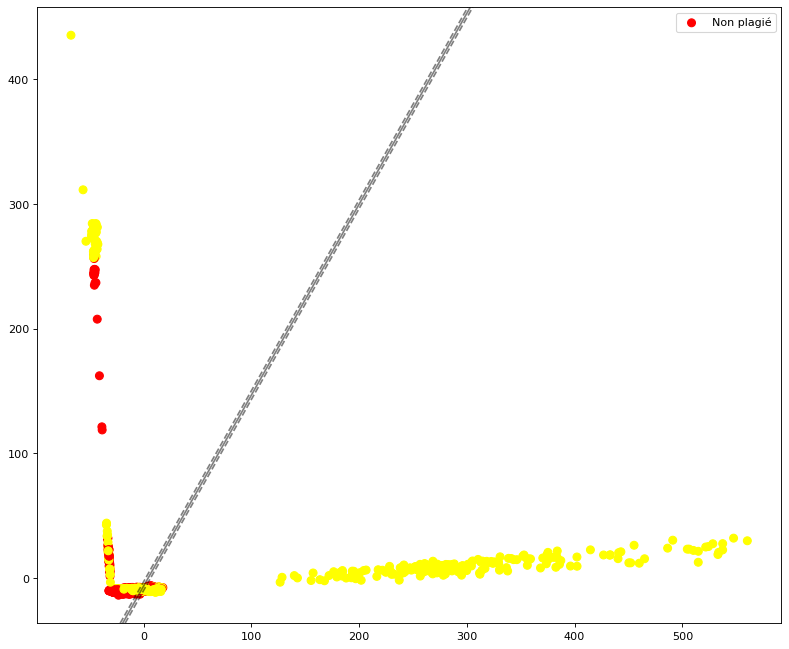

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10), dpi=80)

ax = plt.gca()

plt.scatter(X.iloc[:, 0], X.iloc[:, 1],  c=y, s=50, cmap='autumn', label=['Plagié', 'Non plagié'])

#plt.scatter(clf.support_vectors_[:,0],clf.support_vectors_[:,1])

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
          linestyles=['--', '-', '--'])

#ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
#          linewidth=1, facecolors='none', edgecolors='k')

plt.legend(["Non plagié" , "Plagié"])
plt.show()


In [54]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(df.iloc[:, 13:15], y)

SVC(kernel='linear')

## Entrainement des modèles

### SVM

In [89]:
model=GNN_SVM(768)
optimizer= torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5*10**-4)
loss= torch.nn.BCELoss()

trainer=GNN_SVM_trainer(model)
trainer.compiler(optimizer=optimizer, loss=loss)
import copy

data_copy=copy.deepcopy(data2)

train_loss_SVM= trainer.fit(data_copy, batch_size=16, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:20<12:08, 80.90s/it, loss=0.483]

 20%|██        | 2/10 [03:06<12:43, 95.46s/it, loss=0.205]

 30%|███       | 3/10 [05:14<12:50, 110.08s/it, loss=0.0825]

 40%|████      | 4/10 [07:56<13:05, 130.91s/it, loss=0.0415]

 50%|█████     | 5/10 [12:36<15:22, 184.51s/it, loss=0.0708]

 60%|██████    | 6/10 [16:55<14:00, 210.01s/it, loss=0.0395]

 70%|███████   | 7/10 [21:46<11:48, 236.29s/it, loss=0.012]  

 80%|████████  | 8/10 [28:44<09:48, 294.13s/it, loss=0.00742]

 90%|█████████ | 9/10 [36:24<05:46, 346.04s/it, loss=0.0076] 

100%|██████████| 10/10 [44:08<00:00, 264.82s/it, loss=0.00435]


In [33]:
torch.save(trainer.model.state_dict(), "C:/Users/pc/Desktop/plaag/plagup2/apps/home/model/model.pth")

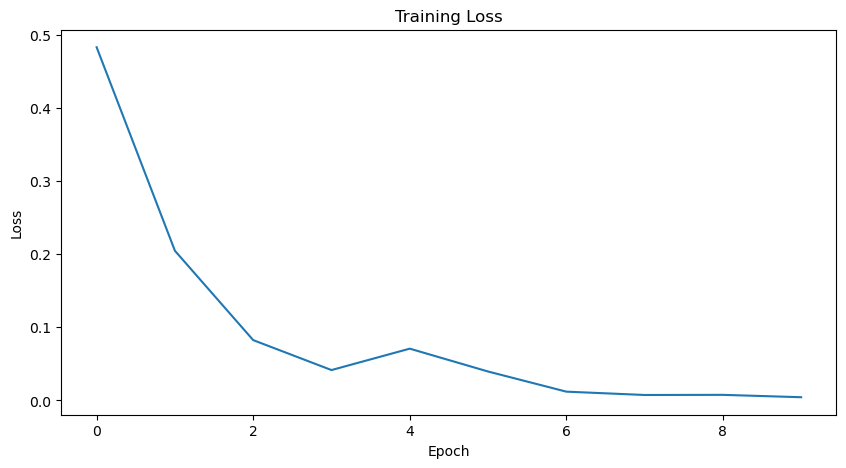

In [90]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_loss_SVM)

#plt.plot(score[0], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [91]:
score_SVM=trainer.evaluate(data_copy)

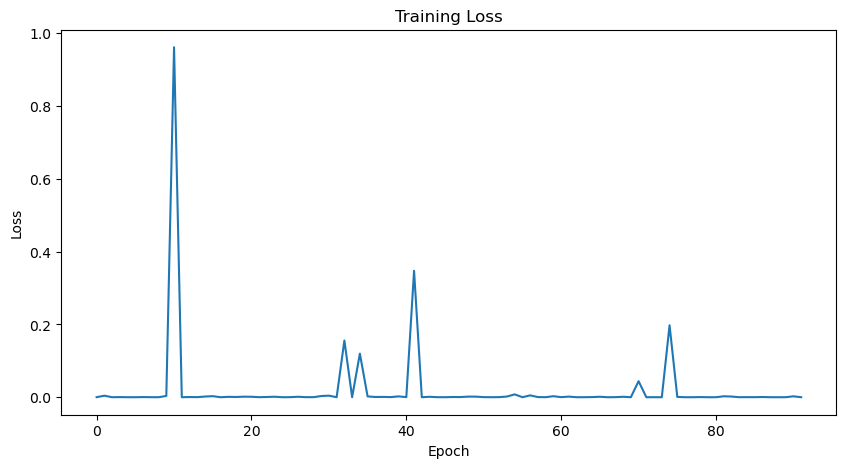

In [92]:
import matplotlib.pyplot as plt
for i in range(len(score_SVM[0])):
    score_SVM[0][i]=score_SVM[0][i].item()

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(score_SVM[0])

#plt.plot(score[0], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### NTN

In [59]:
model3=GNN_NTN(768)
optimizer= torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=5*10**-4)
loss= torch.nn.BCELoss()

trainer3=GNN_NTN_trainer(model3)
trainer3.compiler(optimizer=optimizer, loss=loss)
import copy

data_copy=copy.deepcopy(data2)

train_loss_NTN= trainer3.fit(data_copy, batch_size=16, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:33<05:05, 33.92s/it, loss=2.84]

 20%|██        | 2/10 [01:08<04:32, 34.11s/it, loss=0.462]

 30%|███       | 3/10 [01:43<04:01, 34.57s/it, loss=0.439]

 40%|████      | 4/10 [02:19<03:30, 35.04s/it, loss=0.43] 

 50%|█████     | 5/10 [02:49<02:47, 33.42s/it, loss=0.423]

 60%|██████    | 6/10 [03:20<02:10, 32.54s/it, loss=0.42] 

 70%|███████   | 7/10 [03:51<01:36, 32.03s/it, loss=0.413]

 80%|████████  | 8/10 [04:25<01:05, 32.75s/it, loss=0.426]

 90%|█████████ | 9/10 [04:58<00:32, 32.89s/it, loss=0.403]

100%|██████████| 10/10 [05:30<00:00, 33.05s/it, loss=0.412]


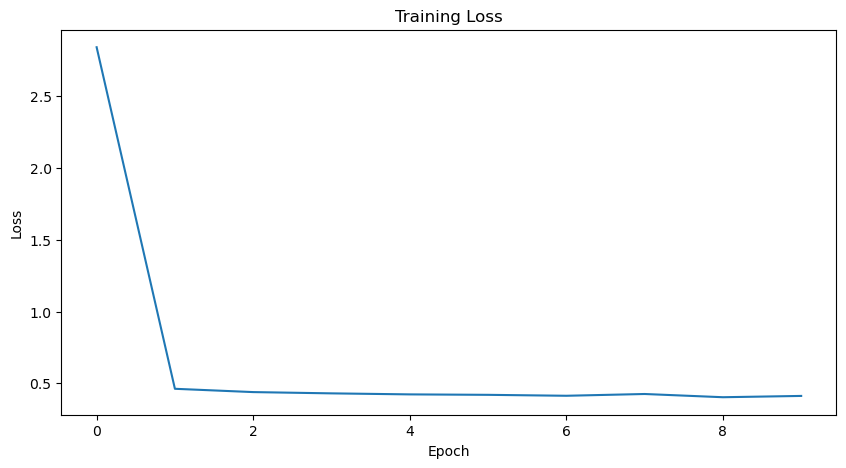

In [60]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_loss_NTN)

#plt.plot(score[0], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [61]:
score_NTN=trainer3.evaluate(data_copy)

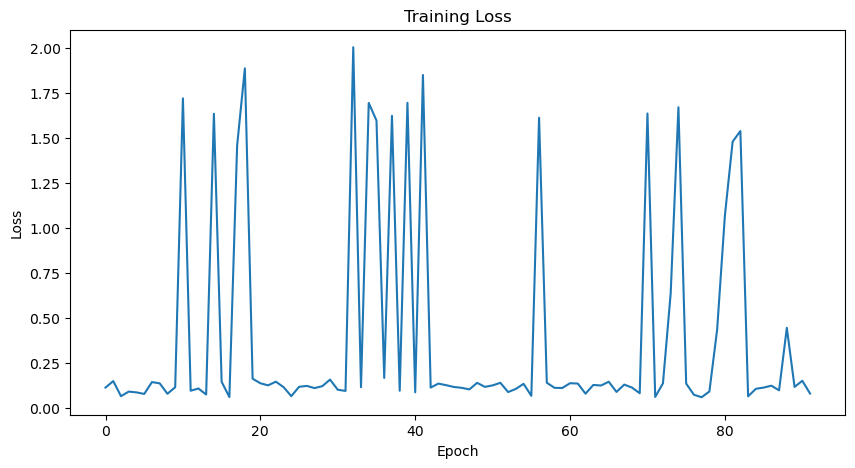

In [63]:
import matplotlib.pyplot as plt
for i in range(len(score_NTN[0])):
    score_NTN[0][i]=score_NTN[0][i].item()

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(score_NTN[0])

#plt.plot(score[0], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### XGBOOST

In [64]:
model2=GNN_XGBOOST(768)
optimizer= torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=5*10**-4)
loss= torch.nn.BCELoss()

trainer2=GNN_XGBOOST_trainer(model2)
trainer2.compiler(optimizer=optimizer, loss=loss)
import copy

data_copy=copy.deepcopy(data2)

train_loss_XGBOOST= trainer2.fit(data_copy, batch_size=16, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:16<02:29, 16.58s/it, loss=76.7]

 20%|██        | 2/10 [00:32<02:11, 16.47s/it, loss=76.7]

 30%|███       | 3/10 [00:49<01:54, 16.35s/it, loss=76.7]

 40%|████      | 4/10 [01:06<01:41, 16.85s/it, loss=77.5]

 50%|█████     | 5/10 [01:23<01:24, 16.98s/it, loss=77.5]

 60%|██████    | 6/10 [01:41<01:08, 17.24s/it, loss=78.3]

 70%|███████   | 7/10 [01:58<00:51, 17.09s/it, loss=78.3]

 80%|████████  | 8/10 [02:16<00:34, 17.34s/it, loss=78.3]

 90%|█████████ | 9/10 [02:33<00:17, 17.37s/it, loss=78.3]

100%|██████████| 10/10 [02:53<00:00, 17.39s/it, loss=77.5]


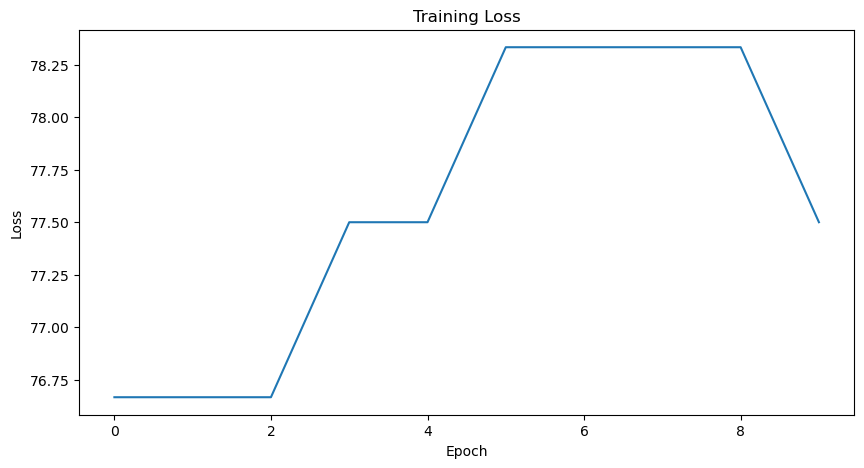

In [65]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_loss_XGBOOST)

#plt.plot(score[0], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [66]:
score_XGBOOST=trainer2.evaluate(data_copy)

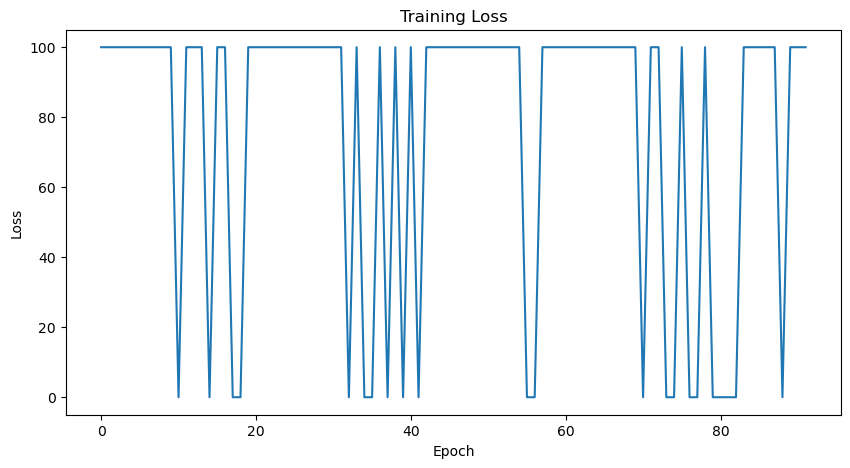

In [67]:
import matplotlib.pyplot as plt
for i in range(len(score_XGBOOST[0])):
    score_XGBOOST[0][i]=score_XGBOOST[0][i].item()

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(score_XGBOOST[0])

#plt.plot(score[0], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Naive Bayes

In [71]:
model4=GNN_Naive(768)
optimizer= torch.optim.Adam(model4.parameters(), lr=0.0001, weight_decay=5*10**-4)
loss= torch.nn.BCELoss()

trainer4=GNN_Naive_trainer(model4)
trainer4.compiler(optimizer=optimizer, loss=loss)
import copy

data_copy=copy.deepcopy(data2)

train_loss_Naive= trainer4.fit(data_copy,  batch_size=100, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:56<08:29, 56.65s/it, loss=23.4]

 20%|██        | 2/10 [01:52<07:27, 55.93s/it, loss=23.4]

 30%|███       | 3/10 [02:48<06:34, 56.31s/it, loss=23.4]

 40%|████      | 4/10 [03:45<05:38, 56.49s/it, loss=23.4]

 50%|█████     | 5/10 [04:35<04:30, 54.03s/it, loss=23.4]

 60%|██████    | 6/10 [05:24<03:29, 52.34s/it, loss=23.4]

 70%|███████   | 7/10 [06:11<02:31, 50.50s/it, loss=23.4]

 80%|████████  | 8/10 [06:58<01:38, 49.49s/it, loss=23.4]

 90%|█████████ | 9/10 [07:44<00:48, 48.54s/it, loss=23.4]

100%|██████████| 10/10 [08:33<00:00, 51.31s/it, loss=23.4]


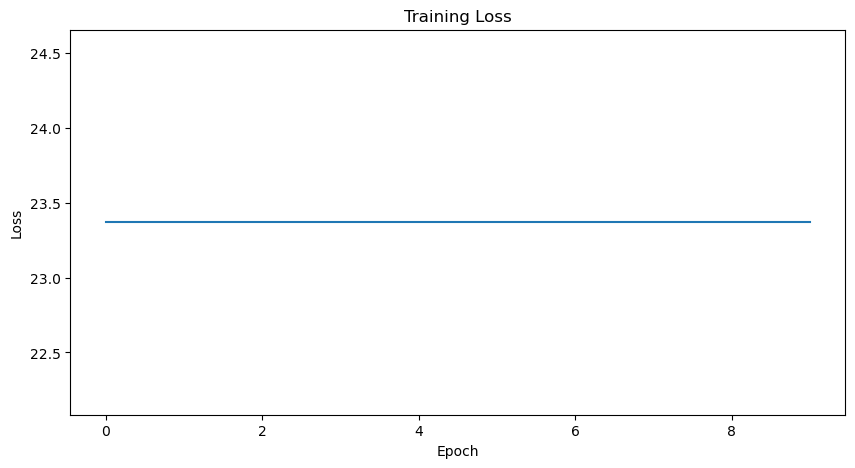

In [72]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_loss_Naive)

#plt.plot(score[0], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [73]:
score_Naive=trainer4.evaluate(data_copy)

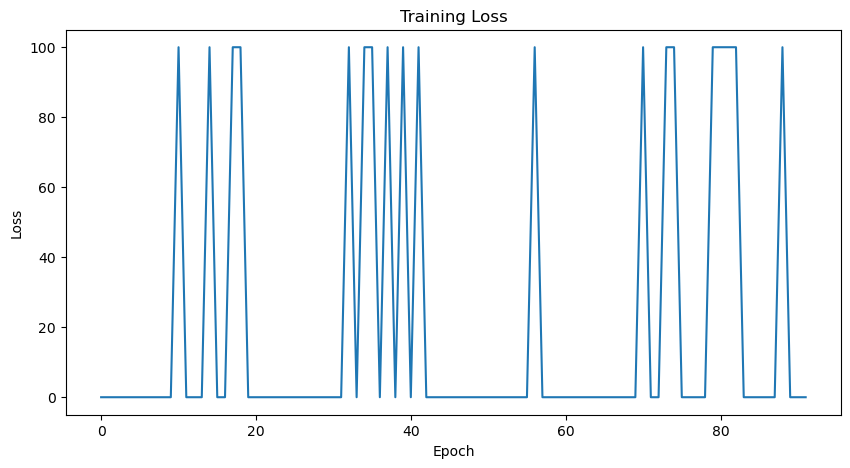

In [74]:
import matplotlib.pyplot as plt
for i in range(len(score_SVM[0])):
    score_Naive[0][i]=score_Naive[0][i].item()

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(score_Naive[0])

#plt.plot(score[0], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Evaluation du model

<Axes: >

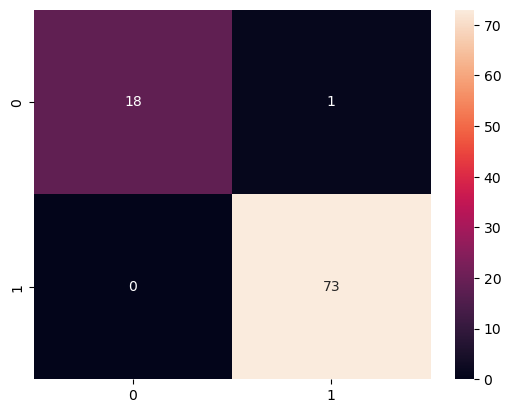

In [93]:
from sklearn import metrics

cf_matrix = metrics.confusion_matrix(score_SVM[3], score_SVM[2])
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

<Axes: >

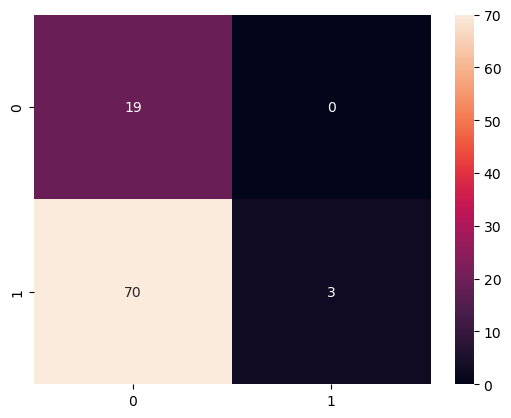

In [94]:
from sklearn import metrics

cf3_matrix = metrics.confusion_matrix(score_XGBOOST[3], score_XGBOOST[2])
import seaborn as sns
sns.heatmap(cf3_matrix, annot=True)

<Axes: >

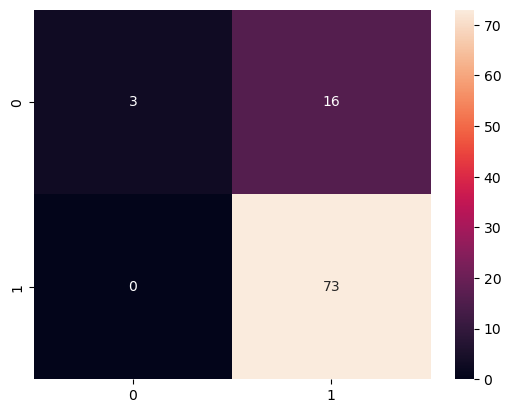

In [95]:
from sklearn import metrics

cf3_matrix = metrics.confusion_matrix(score_NTN[3], score_NTN[2])
import seaborn as sns
sns.heatmap(cf3_matrix, annot=True)

In [96]:
# Importing all necessary libraries
from sklearn.metrics import precision_score

# Calculating the precision score of classifier
precision_SVM=precision_score(score_SVM[3], score_SVM[2])
precision_NTN=precision_score(score_NTN[3], score_NTN[2])
precision_XGBOOST=precision_score(score_XGBOOST[3], score_XGBOOST[2])
precision_Naive=precision_score(score_Naive[3], score_Naive[2])


In [97]:
from sklearn.metrics import recall_score

# Calculating the recall score of classifier
recall_SVM=recall_score(score_SVM[3], score_SVM[2])
recall_NTN=recall_score(score_NTN[3], score_NTN[2])
recall_XGBOOST=recall_score(score_XGBOOST[3], score_XGBOOST[2])
recall_Naive=recall_score(score_Naive[3], score_Naive[2])

In [98]:

# Importing all necessary libraries
from sklearn.metrics import f1_score

# Calculating the F1 score of classifier
f1_SVM=f1_score(score_SVM[3], score_SVM[2])
f1_NTN=f1_score(score_NTN[3], score_NTN[2])
f1_XGBOOST=f1_score(score_XGBOOST[3], score_XGBOOST[2])
f1_Naive=f1_score(score_Naive[3], score_Naive[2])

In [99]:
# Importing all necessary libraries
from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
accuracy_SVM=accuracy_score(score_SVM[3], score_SVM[2])
accuracy_NTN=accuracy_score(score_NTN[3], score_NTN[2])
accuracy_XGBOOST=accuracy_score(score_XGBOOST[3], score_XGBOOST[2])
accuracy_Naive=accuracy_score(score_Naive[3], score_Naive[2])

In [100]:
# Importing all necessary libraries
from sklearn.metrics import roc_auc_score
# Calculating the accuracy of classifier
auc_SVM=roc_auc_score(score_SVM[3], score_SVM[2])
auc_NTN=roc_auc_score(score_NTN[3], score_NTN[2])
auc_XGBOOST=roc_auc_score(score_XGBOOST[3], score_XGBOOST[2])
auc_Naive=roc_auc_score(score_Naive[3], score_Naive[2])

In [101]:
dictionnary={
    "Modèle": ["Notre modèle", "SimGnn", "XGBOOST", "Kmeans"],
    "Accuracy": [accuracy_SVM, accuracy_NTN, accuracy_XGBOOST, accuracy_Naive],
     "Précision":[recall_SVM, recall_NTN, recall_XGBOOST, recall_Naive],
    "Rappel":[precision_SVM, precision_NTN, precision_XGBOOST, precision_Naive],
    "F1_score":[f1_SVM, f1_NTN, f1_XGBOOST, f1_Naive],
    "AUC":[auc_SVM, auc_NTN, auc_XGBOOST, auc_Naive]
    
    
    
}

In [102]:
import pandas as pd
df2=pd.DataFrame(dictionnary)

In [103]:
df2

,Modèle,Accuracy,Précision,Rappel,F1_score,AUC
0,Notre modèle,0.989130,1.000000,0.986486,0.993197,0.973684
1,SimGnn,0.826087,1.000000,0.820225,0.901235,0.578947
2,XGBOOST,0.239130,0.041096,1.000000,0.078947,0.520548
3,Kmeans,0.793478,1.000000,0.793478,0.884848,0.500000


In [104]:
dictionnary2={
    'Métriques': df2.columns[1:],
    'GraphSAGE-SVM': df2.iloc[0,1:],
    'SimGNN':df2.iloc[1, 1:],
    'XGBOOST':df2.iloc[2,1:],
    'Naive Bayes':df2.iloc[3,1:]
}
import pandas as pd
df3=pd.DataFrame(dictionnary2)


<Axes: title={'center': 'Evaluation des modèles de détection de plagiat des codes sources'}, xlabel='Métriques'>

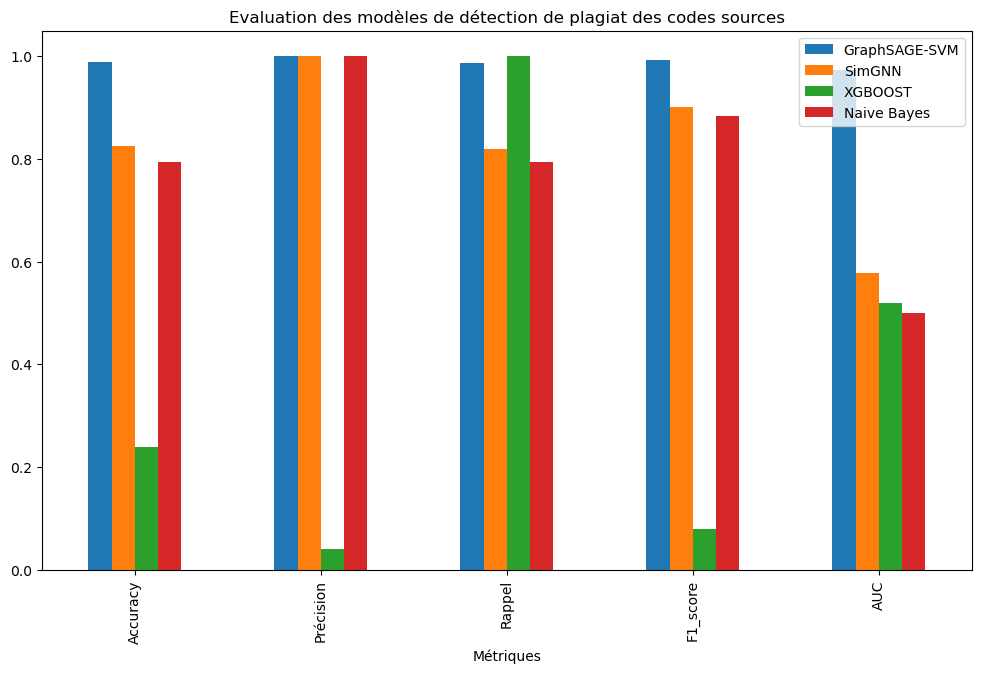

In [105]:
df3.plot(x="Métriques", y=['GraphSAGE-SVM', 'SimGNN', 'XGBOOST', 'Naive Bayes'], kind="bar",figsize=(12,7), title='Evaluation des modèles de détection de plagiat des codes sources')


Text(0.5, 0, 'Epochs')

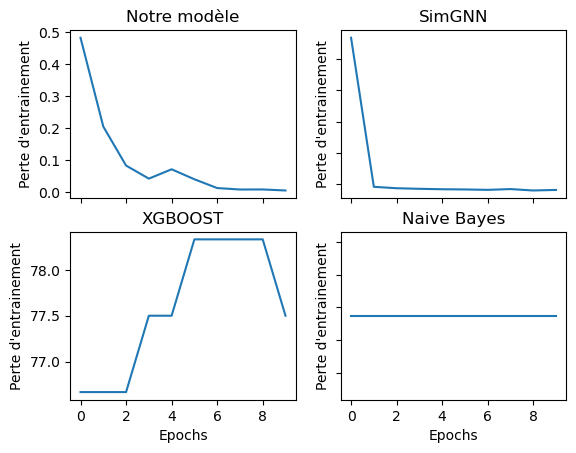

In [106]:
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(train_loss_SVM)
axis[0, 0].set_title("Notre modèle")
  
# For Cosine Function
axis[0, 1].plot(train_loss_NTN)
axis[0, 1].set_title("SimGNN")
  
# For Tangent Function
axis[1, 0].plot(train_loss_XGBOOST)
axis[1, 0].set_title("XGBOOST")
  
# For Tanh Function
axis[1, 1].plot(train_loss_Naive)
axis[1, 1].set_title("Naive Bayes")
for ax in axis.flat:
    ax.label_outer()
    
axis[1,0].set_xlabel("Epochs")
axis[0,0].set_ylabel("Perte d'entrainement")
axis[1,0].set_ylabel("Perte d'entrainement")
axis[0,1].set_ylabel("Perte d'entrainement")
axis[1,1].set_ylabel("Perte d'entrainement")
axis[1,1].set_xlabel("Epochs")

Text(0.5, 0, 'Epochs')

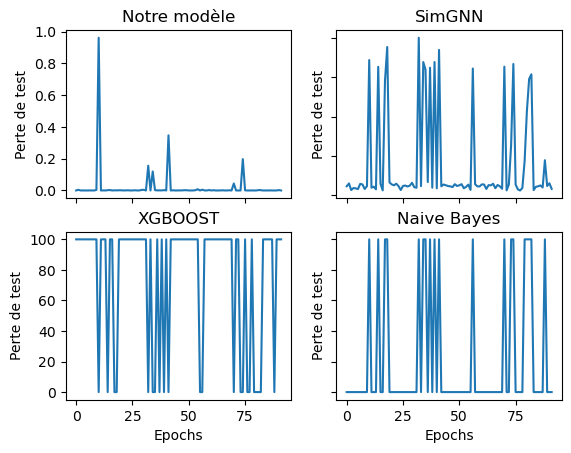

In [107]:
figure, axis = plt.subplots(2, 2)
  
# For Sine Function
axis[0, 0].plot(score_SVM[0])
axis[0, 0].set_title("Notre modèle")
  
# For Cosine Function
axis[0, 1].plot(score_NTN[0])
axis[0, 1].set_title("SimGNN")
  
# For Tangent Function
axis[1, 0].plot(score_XGBOOST[0])
axis[1, 0].set_title("XGBOOST")
  
# For Tanh Function
axis[1, 1].plot(score_Naive[0])
axis[1, 1].set_title("Naive Bayes")
for ax in axis.flat:
    ax.label_outer()
    
axis[1,0].set_xlabel("Epochs")
axis[0,0].set_ylabel("Perte de test")
axis[1,0].set_ylabel("Perte de test")
axis[0,1].set_ylabel("Perte de test")
axis[1,1].set_ylabel("Perte de test")
axis[1,1].set_xlabel("Epochs")

In [108]:
from sklearn.metrics import roc_auc_score, roc_curve
roc=roc_auc_score(score_SVM[3], score_SVM[2])
roc

0.9736842105263158

Text(0, 0.5, 'Taux de vrais positifs')

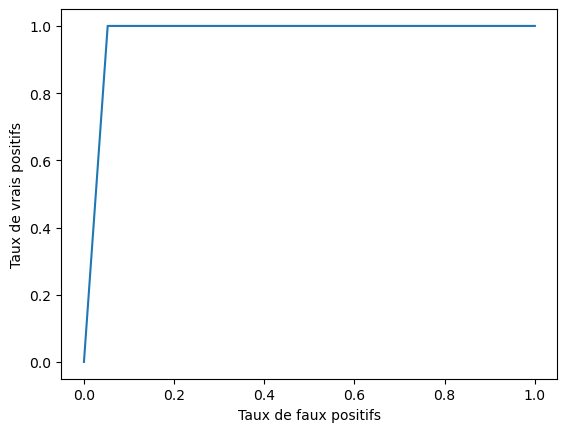

In [109]:
    fpr, tpr, thresholds = roc_curve(score_SVM[3], score_SVM[2])
    plt.plot(fpr, tpr)
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')